In [1]:
import scipy.interpolate
import numpy
%matplotlib notebook
import matplotlib.pyplot

# Intersections

## Overview

With the model determined for creating turns, we need to specify the model for entire intersections. The idea is to specify each lane of the road as it enters and exits the intersection. The turning model will be applied from each entering lane to each exiting lane.

## Defining Intersections

Each lane will be represented by a short parametric equation. They will be split based on whether they are entering or exiting the intersection. A general example of $m$ entering lanes each defined as straight lines between $\langle x_a, y_a \rangle$ and $\langle x_b, y_b \rangle$ would look like:

$$ L_{\mathrm{enter}} = \begin{pmatrix}
    x^{(1)}_a + \left(x^{(1)}_b - x^{(1)}_a\right) t & y^{(1)}_a + \left(y^{(1)}_b - y^{(1)}_a\right) t \\
    x^{(2)}_a + \left(x^{(2)}_b - x^{(2)}_a\right) t & y^{(2)}_a + \left(y^{(2)}_b - y^{(2)}_a\right) t \\
    \vdots & \vdots \\
    x^{(m)}_a + \left(x^{(m)}_b - x^{(m)}_a\right) t & y^{(m)}_a + \left(y^{(m)}_b - y^{(m)}_a\right) t
\end{pmatrix} $$

For simplicity, we will consider a standard two lane road at a four-way stop. Using the definition above

$$ L_{\mathrm{enter}} = \begin{pmatrix}
    t & 2 \\
    3 & t \\
    5 - t & 3 \\
    2 & 5 - t
\end{pmatrix}, \quad L_{\mathrm{exit}} = \begin{pmatrix}
    1 - t & 3 \\
    2 & 1 - t \\
    4 + t & 2 \\
    3 & 4 + t
\end{pmatrix} $$


In [2]:
enter = [
    lambda t: numpy.array([[0 + 1 * t], [2 + 0 * t]]),
    lambda t: numpy.array([[3 + 0 * t], [0 + 1 * t]]),
    lambda t: numpy.array([[5 - 1 * t], [3 + 0 * t]]),
    lambda t: numpy.array([[2 + 0 * t], [5 - 1 * t]])
]
exit = [
    lambda t: numpy.array([[1 - 1 * t], [3 + 0 * t]]),
    lambda t: numpy.array([[2 + 0 * t], [1 - 1 * t]]),
    lambda t: numpy.array([[4 + 1 * t], [2 + 0 * t]]),
    lambda t: numpy.array([[3 + 0 * t], [4 + 1 * t]])
]

Let's plot it to confirm it makes sense. The entering lanes are shown in red and the exiting in blue.

<IPython.core.display.Javascript object>


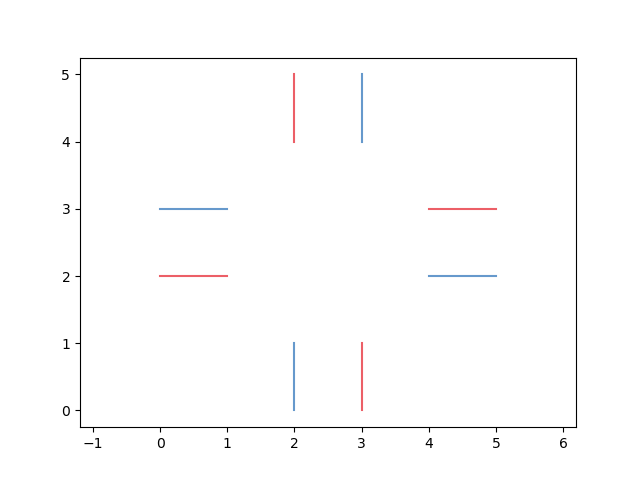

In [3]:
fig, ax = matplotlib.pyplot.subplots()

t = numpy.linspace(0, 1, 100)

for enter_i in enter:
    ax.plot(enter_i(t)[0].flatten(), enter_i(t)[1].flatten(), '#ec5f67')
    
for exit_i in exit:
    ax.plot(exit_i(t)[0].flatten(), exit_i(t)[1].flatten(), '#6699cc')

ax.axis('equal')
    
matplotlib.pyplot.show()

## Defining Turns

With the intersection defined, we need a way to get all possible turns within the intersection. We'll accomplish this by feeding all entering and exiting lanes into a function that will calculate turns between all combinations of entering-exiting pairs. The result will be a matrix of parametric functions where index $ij$ will correspond with entering the intersection in lane $i$ and exiting in lane $j$.

First, we copy a method which combines the work from the Spline Turns notebook.

In [4]:
def get_path(l_a, l_b):

    t = numpy.linspace(0, 1, 100)

    x = numpy.hstack([l_a(t)[0].flatten(), l_b(t)[0].flatten()])
    y = numpy.hstack([l_a(t)[1].flatten(), l_b(t)[1].flatten()])
    points = [x, y]

    spline, _ = scipy.interpolate.splprep(points, s=0)

    return lambda t: scipy.interpolate.splev(t, spline)

Then, we can define a method to calculate all turns in the intersection.

In [5]:
def get_turn_matrix(enter, exit):
    
    turn_matrix = [[None for j in range(len(exit))] for i in range(len(enter))]
    
    for i in range(len(enter)):
        for j in range(len(exit)):
            turn_matrix[i][j] = get_path(enter[i], exit[j])
    
    return turn_matrix

In [6]:
turn_matrix = get_turn_matrix(enter, exit)

Let's plot the turns for all entering lanes to confirm the results.

<IPython.core.display.Javascript object>


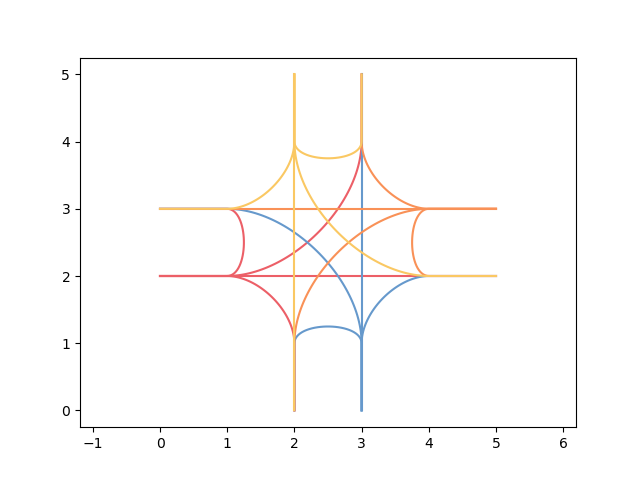

In [7]:
fig, ax = matplotlib.pyplot.subplots()

t = numpy.linspace(0, 1, 100)

color = [ '#ec5f67', '#6699cc', '#f99157', '#fac863' ]

for i in range(len(turn_matrix)):
    for j in range(len(turn_matrix[0])):
        ax.plot(turn_matrix[i][j](t)[0].flatten(), turn_matrix[i][j](t)[1].flatten(), color[i])

ax.axis('equal')
    
matplotlib.pyplot.show()

Note that U-turns are accounted for, but they don't necessarily need to be used. When intersections become more complex, some lanes are only allowed to travel in specific directions. In that case, just ignore the turn returned by the intersection matrix.

## Conclusion

The turn matrix will connect any entering and exiting lanes. For traditional intersections, this will be very useful. The model should remain flexible for very specific intersections, but their turns will probably be specified individually as they will need to be more rigid and complex.